In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [48]:
def read_data(file):
	data_f = open(file)
	data_a = np.loadtxt(data_f, delimiter=",")
	data_X = np.delete(data_a, -1, axis=1)
	data_y = data_a[:,2]
	return data_X, data_y

def weak_classifier(data_X, data_y, weights):
	n_samples, d_features = data_X.shape
	epsilon_min = float('inf') # minimizing the weighted training error
	classifier = {}

	# iterate through all possible decision stumps
	# potential dividing line comes from the training data values
	for d in range(d_features):
		X_d = data_X[:, d]
		pdls = np.sort(X_d) # list of potential dividing line
		pdls = np.insert(pdls, 0, min(pdls)-0.000001) # You should also consider the decision stumps that classifies every training data point as positive or negative
		for pdl in pdls:
			label = 1
			pred = np.full(n_samples, -1)
			pred[X_d > pdl] = 1
			
			# Compute the weighted training error of ℎt (epsilon)
			epsilon_h = sum(weights[data_y != pred])
			# determine which side should be classified as +1
			if epsilon_h > 0.5:
				label = -1
				#epsilon_h = 1 - epsilon_h ### !!!! cannot do this because of Limitations of Floating Point Arithmetic
				epsilon_h = sum(weights[data_y == pred])

			# update the best weak classifier
			if epsilon_h < epsilon_min:
				pred = pred * label
				epsilon_min = epsilon_h
				classifier = {'dimension':d, 'dividing_line':pdl, 'label':label, 'pred': pred, 'weights': tuple(weights)}

	# Compute the importance of ℎt
	alpha = (np.log((1 - epsilon_min) / epsilon_min)) / 2
	classifier['alpha'] = alpha
	return classifier

def update_weights(weights, alpha, data_y, pred):
	weights *= np.exp(-alpha * data_y * pred)
	weights /= np.sum(weights)
	return weights

def adaboost_predict(data_X, hlist):
	n_samples = data_X.shape[0]
	# returns the predicted labels for each weak classifier
	for clf in hlist:
		X_d = data_X[:, clf['dimension']]
		pred = np.full(n_samples, -1)
		if clf['label'] == 1:
			pred[X_d > clf['dividing_line']] = 1
		else:
			pred[X_d < clf['dividing_line']] = 1
		clf['pred'] = pred
	# output: an aggregated hypothesis
	pred_votes = [clf['alpha'] * clf['pred'] for clf in hlist]
	pred = np.sign(np.sum(pred_votes, axis = 0))
	return pred

def eval_model(X_test, y_test, hlist):
	# returns the predicted labels for each weak classifier
	pred = adaboost_predict(X_test, hlist)
	accuracy = np.sum(y_test == pred) / len(y_test)
	return pred, accuracy

def Adaboost_train(num_iter, X_train, y_train, X_test, y_test):
	# Initialize input weights: w1, ..., wn = 1/n
	n_samples = X_train.shape[0]
	weights = np.full(n_samples, (1/n_samples))
	# list of classifiers
	hlist = []
	accuracy_list = []

	for t in range(num_iter):
		# finds the best weak classifier
		clf = weak_classifier(X_train, y_train, weights)
		# Save classifier
		hlist.append(clf)
		# computes the updated weights
		weights = update_weights(weights, clf['alpha'], y_train, clf['pred'])
		# test classifier
		pred, accuracy = eval_model(X_test, y_test, hlist)
		accuracy_list.append([t, accuracy])
	return hlist, accuracy_list

(0.0022025276430739224, 0.0026829382256565175, 0.002297956869866314, 0.0011504092597939169, 0.0011504092597939169, 0.0023094682132704914, 0.0011504092597939169, 0.0011504092597939169, 0.0011504092597939169, 0.0022025276430739224, 0.0011504092597939169, 0.002558704022299557, 0.0011504092597939169, 0.004399576485831536, 0.002558704022299557, 0.0021915493356389325, 0.002014999092767503, 0.005136646420706623, 0.002014999092767503, 0.002014999092767503, 0.002297956869866314, 0.0026829382256565175, 0.0011504092597939169, 0.0026829382256565175, 0.0021915493356389325, 0.0023094682132704914, 0.004481697482613944, 0.004481697482613944, 0.0026829382256565175, 0.005136646420706623, 0.004481697482613944, 0.002558704022299557, 0.002297956869866314, 0.0022025276430739224, 0.002297956869866314, 0.005136646420706623, 0.0023094682132704914, 0.002297956869866314, 0.002297956869866314, 0.0022025276430739224, 0.0022025276430739224, 0.0021915493356389325, 0.0011504092597939169, 0.0011504092597939169, 0.0011

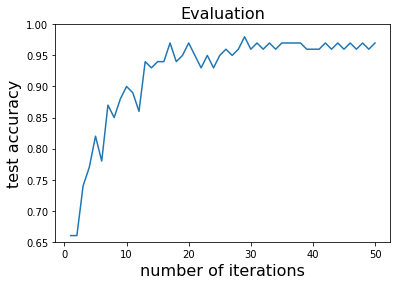

0.97


In [49]:
def main():

	# Input: D(y = {-1, +1}), T
	num_iter = 50

	X_train, y_train = read_data("train_adaboost.csv")
	X_test, y_test = read_data("test_adaboost.csv")

	hlist, accuracy_list = Adaboost_train(num_iter, X_train, y_train, X_test, y_test)
	# check implementation 
	print(hlist[5]['weights'])
	print(hlist[10]['weights'])
	
	# plot for Q6.2
	accuracy_arr = np.array(accuracy_list)
	x_coordinates = accuracy_arr[:,0] + 1
	y_coordinates = accuracy_arr[:,1]
 
	plt.plot(x_coordinates, y_coordinates)
	plt.ylim(0.65,1)
	plt.title('Evaluation', fontsize=16)
	plt.xlabel('number of iterations', fontsize=16)
	plt.ylabel('test accuracy', fontsize=16)
	plt.show()

	final_pred, final_acc = eval_model(X_test, y_test, hlist)
	print(final_acc)


if __name__ == '__main__':
	main()

## For Q6.1

In [50]:
# A scatter plot of the first 20 training data points, where points with label +1 are blue +’s, points with label -1 are red -’s and 
# each point’s size is proportional to its weight squared. Specifically, the formula you should use for a point’s size is 
X_train, y_train = read_data("train_adaboost.csv")

num_iter = 3

# Initialize input weights: w1, ..., wn = 1/n
n_samples = X_train.shape[0]
weights = np.full(n_samples, (1/n_samples))
# list of classifiers
hlist = [] 

for t in range(num_iter):
    # finds the best weak classifier
    clf = weak_classifier(X_train, y_train, weights)
    # Save classifier
    hlist.append(clf)
    # computes the updated weights
    weights = update_weights(weights, clf['alpha'], y_train, clf['pred'])

0.6545060972304506 1 0


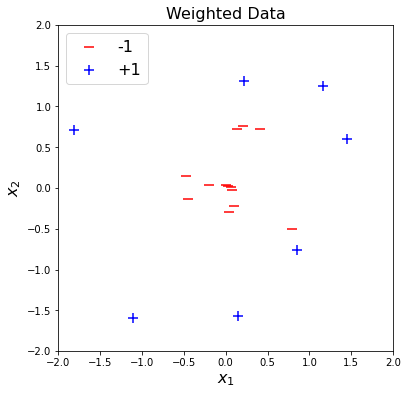

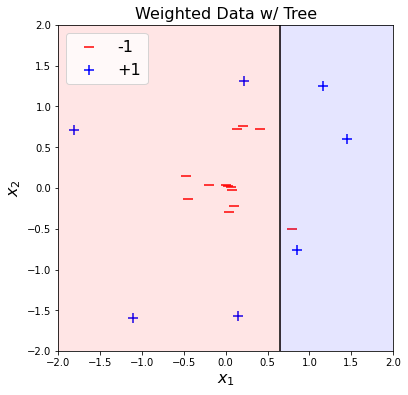

In [51]:
# iter1
iter = 1
clf_h = hlist[iter-1]

datapoints = np.hstack((X_train, np.reshape(y_train, (400,1))))
datapoints = np.hstack((datapoints, np.reshape(clf_h['weights'], (400,1))))
datapoints_20 = datapoints[:20, :]

pos_x = datapoints_20[np.where(datapoints_20[:,2] == 1)]
neg_x = datapoints_20[np.where(datapoints_20[:,2] == -1)]
pos_weights = pos_x[:, 3]
neg_weights = neg_x[:, 3]
pos_x = pos_x[:,:2]
neg_x = neg_x[:,:2]

db = clf_h['dividing_line']
print(db, clf_h['label'], clf_h['dimension'])

##############################

plt.figure(figsize=(6,6))
plt.scatter(neg_x[:, 0], neg_x[:, 1], s=(400*neg_weights)**2 * 100, color='red', marker='_')
plt.scatter(pos_x[:, 0], pos_x[:, 1], s=(400*pos_weights)**2 * 100, color='blue', marker='+')
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.title('Weighted Data', fontsize=16)
plt.legend(['-1', '+1'], fontsize=16, loc=2)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(neg_x[:, 0], neg_x[:, 1], s=(400*neg_weights)**2 * 100, color='red', marker='_')
plt.scatter(pos_x[:, 0], pos_x[:, 1], s=(400*pos_weights)**2 * 100, color='blue', marker='+')

plt.plot([db, db], [-2, 2], color='black', label='_nolegend_')
plt.fill([-2, -2, db, db], [-2, 2, 2, -2], color='red', alpha=0.1, label='_nolegend_')
plt.fill([2, 2, db, db], [-2, 2, 2, -2], color='blue', alpha=0.1, label='_nolegend_')
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.title('Weighted Data w/ Tree', fontsize=16)
plt.legend(['-1', '+1'], fontsize=16, loc=2)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.show()

-0.3339807292899099 -1 0


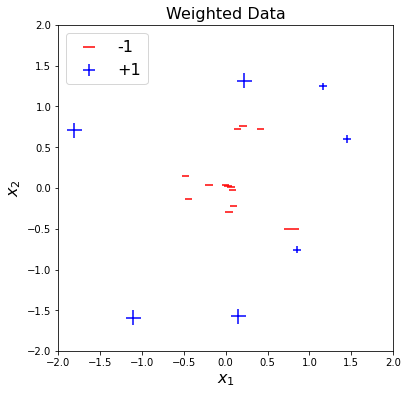

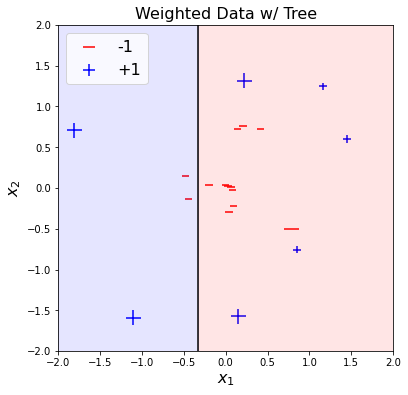

In [52]:
# iter2
iter = 2
clf_h = hlist[iter-1]

datapoints = np.hstack((X_train, np.reshape(y_train, (400,1))))
datapoints = np.hstack((datapoints, np.reshape(clf_h['weights'], (400,1))))
datapoints_20 = datapoints[:20, :]

pos_x = datapoints_20[np.where(datapoints_20[:,2] == 1)]
neg_x = datapoints_20[np.where(datapoints_20[:,2] == -1)]
pos_weights = pos_x[:, 3]
neg_weights = neg_x[:, 3]
pos_x = pos_x[:,:2]
neg_x = neg_x[:,:2]

db = clf_h['dividing_line']
print(db, clf_h['label'], clf_h['dimension'])

##############################

plt.figure(figsize=(6,6))
plt.scatter(neg_x[:, 0], neg_x[:, 1], s=(400*neg_weights)**2 * 100, color='red', marker='_')
plt.scatter(pos_x[:, 0], pos_x[:, 1], s=(400*pos_weights)**2 * 100, color='blue', marker='+')
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.title('Weighted Data', fontsize=16)
plt.legend(['-1', '+1'], fontsize=16, loc=2)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(neg_x[:, 0], neg_x[:, 1], s=(400*neg_weights)**2 * 100, color='red', marker='_')
plt.scatter(pos_x[:, 0], pos_x[:, 1], s=(400*pos_weights)**2 * 100, color='blue', marker='+')

plt.plot([db, db], [-2, 2], color='black', label='_nolegend_')
plt.fill([2, 2, db, db], [-2, 2, 2, -2], color='red', alpha=0.1, label='_nolegend_')
plt.fill([-2, -2, db, db], [-2, 2, 2, -2], color='blue', alpha=0.1, label='_nolegend_')
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.title('Weighted Data w/ Tree', fontsize=16)
plt.legend(['-1', '+1'], fontsize=16, loc=2)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.show()

-1.9913349119318706 1 0


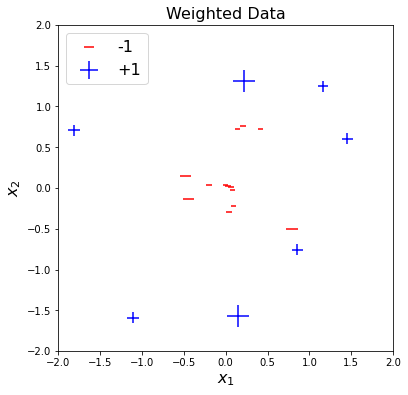

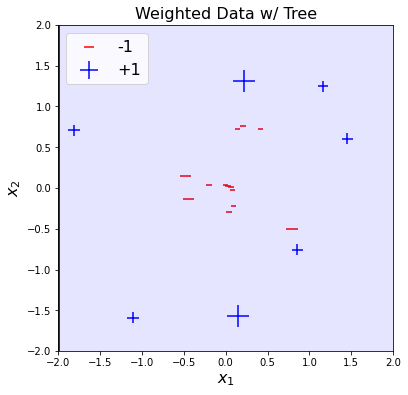

In [54]:
# iter3
iter = 3
clf_h = hlist[iter-1]

datapoints = np.hstack((X_train, np.reshape(y_train, (400,1))))
datapoints = np.hstack((datapoints, np.reshape(clf_h['weights'], (400,1))))
datapoints_20 = datapoints[:20, :]

pos_x = datapoints_20[np.where(datapoints_20[:,2] == 1)]
neg_x = datapoints_20[np.where(datapoints_20[:,2] == -1)]
pos_weights = pos_x[:, 3]
neg_weights = neg_x[:, 3]
pos_x = pos_x[:,:2]
neg_x = neg_x[:,:2]

db = clf_h['dividing_line']
print(db, clf_h['label'], clf_h['dimension'])

##############################

plt.figure(figsize=(6,6))
plt.scatter(neg_x[:, 0], neg_x[:, 1], s=(400*neg_weights)**2 * 100, color='red', marker='_')
plt.scatter(pos_x[:, 0], pos_x[:, 1], s=(400*pos_weights)**2 * 100, color='blue', marker='+')
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.title('Weighted Data', fontsize=16)
plt.legend(['-1', '+1'], fontsize=16, loc=2)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(neg_x[:, 0], neg_x[:, 1], s=(400*neg_weights)**2 * 100, color='red', marker='_')
plt.scatter(pos_x[:, 0], pos_x[:, 1], s=(400*pos_weights)**2 * 100, color='blue', marker='+')

plt.plot([db, db], [-2, 2], color='black', label='_nolegend_')
plt.fill([-2, -2, db, db], [-2, 2, 2, -2], color='red', alpha=0.1, label='_nolegend_')
plt.fill([2, 2, db, db], [-2, 2, 2, -2], color='blue', alpha=0.1, label='_nolegend_')
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.title('Weighted Data w/ Tree', fontsize=16)
plt.legend(['-1', '+1'], fontsize=16, loc=2)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.show()